In [1]:
from IPython.core.display import HTML
HTML("""
<style>
font-family: monospace;
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: AliceBlue;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h2 {
    text-align: center;
    background-color: HoneyDew;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h3 {
    text-align: center;
    background-color: MintCream;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")



# Graph Mode vs Eager Mode. Improve drastically and easily the performance of your TensorFlow Notebooks. 
Code in graph mode is much more efficient and can give us a huge performance boost.

In the notebook, we will see a brief introduction to graph mode. At first, we will see their differences and a few examples of how the code looks in graph mode, as well as how we can easily go from eager mode to graph mode.

After the brief introduction, we will move on to solving a classification problem with the cats_vs_dogs dataset. With code in eager mode and code in graph mode, so we can compare performance differences.

## brief introduction to graph mode & differences with eager mode
To simplify, the eager mode is more intuitive, easier to code and debug, and is the natural way to develop. The graph mode is better for performance. 

Let's look at some code, in eager and graph mode. 

#### Eager Mode
def func(x):

    if x > 0:
    
        x = x + 1
        
    return x

#### Graph Mode
def func(x):

    def if_true():
    
        return x + 1
        
    def if_false():
    
        return x
        
    x = tf.cond(tf.greater(x, 0), if_true, if_false)
    
    return x
    
As you can see, the code in graph mode is much more difficult to write and understand than the code in eager mode. But there is great news. We do not need to write the code in graph mode. Autograph does it for us.

Another great news is that the two types of code can coexist. So, we can use graph mode only for those functions that are expensive in time.

### Trying the autograph. 
We are going to use the autograph to convert some functions from eager to graph. 


In [2]:
import tensorflow as tf
import time

In [3]:
@tf.function
def func(X):
    if x > 0: 
        x = x + 1
    return x

We have decorated our function with @tf.function. We don't see it, but when we call it, it will run in graph mode. Now let's see the generated code.

In [4]:
print (tf.autograph.to_code(func.python_function))

def tf__func(X):
    with ag__.FunctionScope('func', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def if_body():
            nonlocal x
            x = (ag__.ld(x) + 1)

        def else_body():
            nonlocal x
            pass
        x = ag__.Undefined('x')
        ag__.if_stmt((ag__.ld(x) > 0), if_body, else_body, get_state, set_state, ('x',), 1)
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



Ok! That's the code autogenerated in graph mode. As you can see is even more complex that the one that i writed as a sample. But the structure is similar.  The functions used are defined at the beginning, and we execute the code inside a function calling the functions witted previously. 

You may ask,why can't I decorate every function in the notebook?  Easy, not all works fine in graph mode, there are some tricks that we must know. 



If we need to use Tensor variables, they can't be declared inside the function. 

In [5]:
#This function will fail as it does not support declaring tf variables in the body. 
#if you want to execute and test it, remove the comments. 

#@tf.function
#def f(x):
#    v = tf.Variable(1.0)
#    return v.assign_add(x)

#print(f(5))

In [6]:
#For it to work, we just have to remove the variable and declare it outside the function
v = tf.Variable(1.0)
@tf.function
def f(x):
    return v.assign_add(x)

print(f(5))

2022-10-27 22:42:58.768253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


tf.Tensor(6.0, shape=(), dtype=float32)


2022-10-27 22:42:58.863410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 22:42:58.864152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 22:42:58.865319: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 22:42:58.865607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Another thing to consider is how the print() function works. In graphical mode, it will only execute once, no matter how many times we call it in a loop. 

We must replace it with tf.print().

In [7]:
@tf.function
def print_test(): 
    tf.print("with tf.print")
    print("with print")
    

for i in range(5):
    print_test()

with print
with tf.print
with tf.print
with tf.print
with tf.print
with tf.print


# Compare eager vs graph using the Cats vs Dogs dataset. 

In [8]:
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np

## Import & data

In [9]:
#setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
splits_horses_humans, info_cd = tfds.load('horses_or_humans', 
                         as_supervised=True, 
                         with_info=True, 
                         split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'], 
                         data_dir='./data')

2022-10-27 22:43:04.137247: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling horses_or_humans-train.tfrecord...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling horses_or_humans-test.tfrecord...:   0%|          | 0/256 [00:00<?, ? examples/s]

Dataset horses_or_humans downloaded and prepared to ./data/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [10]:
num_examples_cd = info_cd.splits['train'].num_examples
num_classes_cd = info_cd.features['label'].num_classes

splits = splits_horses_humans
(train_examples, validation_examples, test_examples) = splits
num_examples = num_examples_cd
num_classes = num_classes_cd

## Eager vs Graph

In [11]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [12]:
def map_fn_eager(img, label):
    # resize the image
    img = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
    # normalize the image
    img /= 255.0
    return img, label

In [13]:
# Create a autograph pre-processing function to resize and normalize an image
@tf.function
def map_fn_graph(img, label):
    # resize the image
    img = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
    # normalize the image
    img /= 255.0
    return img, label

In [14]:
# Prepare train dataset by using preprocessing with map_fn, shuffling and batching
def prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, batch_size):
    train_ds = train_examples.map(map_fn).shuffle(buffer_size = num_examples).batch(batch_size)
    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)
    
    return train_ds, valid_ds, test_ds

In [15]:
start_time = time.time()
train_ds_eager, valid_ds_eager, test_ds_eager = prepare_dataset(train_examples, 
                                                                validation_examples, 
                                                                test_examples, 
                                                                num_examples, 
                                                                map_fn_eager, BATCH_SIZE)
end_time = time.time()
print ("Time spend:",  end_time - start_time)

Time spend: 0.05977654457092285


In [16]:
start_time = time.time()
train_ds_graph, valid_ds_graph, test_ds_graph = prepare_dataset(train_examples, 
                                                                validation_examples, 
                                                                test_examples, 
                                                                num_examples, 
                                                                map_fn_graph, BATCH_SIZE)
end_time = time.time()
print ("Time spend:",  end_time - start_time)

Time spend: 0.056015729904174805


# THE MODEL

In [17]:
#MODULE_HANDLE = 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1'
#MODULE_HANDLE = 'https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5'
#model = tf.keras.Sequential([
#    hub.KerasLayer(MODULE_HANDLE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
#    tf.keras.layers.Dense(num_classes, activation='softmax')
#])
model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (4,4), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Dropout(0.2),   
            tf.keras.layers.Conv2D(32, (4,4), activation="relu"),
            tf.keras.layers.MaxPooling2D(2,2),  
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.Conv2D(64, (4,4), activation="relu"),
            tf.keras.layers.MaxPooling2D(2,2),  
            tf.keras.layers.Dropout(0.5), 
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(512, activation="relu"), 
            tf.keras.layers.Dense(2, activation="softmax")])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 221, 221, 16)      784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 32)      8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        3

In [18]:
optimizer = tf.keras.optimizers.Adam()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
val_loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [19]:
# Custom training step
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        # Run the model on input x to get predictions
        predictions = model(x)
        # Compute the training loss using `train_loss`, passing in the true y and the predicted y
        loss = train_loss(y, predictions)

    # Using the tape and loss, compute the gradients on model variables using tape.gradient
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y, predictions)
    return loss

In [20]:
def train_eager(model, optimizer, epochs, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            # training step number increments at each iteration
            step += 1

            # Run one training step by passing appropriate model parameters
            # required by the function and finally get the loss to report the results
            loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)

            # Use tf.print to report your results.
            # Print the training step number, loss and accuracy
            print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

        for x, y in valid_ds:
            # Call the model on the batches of inputs x and get the predictions
            y_pred = model(x)
            loss = val_loss(y, y_pred)
            val_accuracy(y, y_pred)
        # Print the validation loss and accuracy
        
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())

In [21]:
@tf.function
def train_graph(model, optimizer, epochs, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            # training step number increments at each iteration
            step += 1

            # Run one training step by passing appropriate model parameters
            # required by the function and finally get the loss to report the results
            loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)

            # Use tf.print to report your results.
            # Print the training step number, loss and accuracy
            tf.print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

        for x, y in valid_ds:
            # Call the model on the batches of inputs x and get the predictions
            y_pred = model(x)
            loss = val_loss(y, y_pred)
            val_accuracy(y, y_pred)

        # Print the validation loss and accuracy
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())

In [22]:
st = time.time()
train_eager(model, optimizer, 6, train_ds_eager, 
            train_loss, train_accuracy, valid_ds_eager, 
            val_loss, val_accuracy)
et = time.time()
print(et - st)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Step 1 : train loss tf.Tensor(0.67511785, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.59375, shape=(), dtype=float32)
Step 2 : train loss tf.Tensor(6.773117, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.5625, shape=(), dtype=float32)
Step 3 : train loss tf.Tensor(1.0820602, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.5520833, shape=(), dtype=float32)
Step 4 : train loss tf.Tensor(0.88482773, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.5390625, shape=(), dtype=float32)
Step 5 : train loss tf.Tensor(0.5710093, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.61875, shape=(), dtype=float32)
Step 6 : train loss tf.Tensor(0.55187666, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.671875, shape=(), dtype=float32)
Step 7 : train loss tf.Tensor(0.5106777, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.6875, shape=(), dtype=float32)
Step 8 : train loss tf.Tensor(0.5586562, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.68359375, s

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

val loss 0.119136244 ; val accuracy 0.956097543
Step 24 : train loss tf.Tensor(0.110709846, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.81091875, shape=(), dtype=float32)
Step 25 : train loss tf.Tensor(0.12433482, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.8173691, shape=(), dtype=float32)
Step 26 : train loss tf.Tensor(0.11623803, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.8233129, shape=(), dtype=float32)
Step 27 : train loss tf.Tensor(0.037612148, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.8299882, shape=(), dtype=float32)
Step 28 : train loss tf.Tensor(0.5025737, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.82935154, shape=(), dtype=float32)
Step 29 : train loss tf.Tensor(0.37025994, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.83095497, shape=(), dtype=float32)
Step 30 : train loss tf.Tensor(0.19864067, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.8335101, shape=(), dtype=float32)
Step 31 : train loss tf.Tensor(

In [23]:
st = time.time()
train_graph(model, optimizer, 6, train_ds_graph, 
            train_loss, train_accuracy, valid_ds_graph, 
            val_loss, val_accuracy)
et = time.time()
print(et - st)

Step 1 : train loss 0.00406656228 ; train accuracy 0.945237
Step 2 : train loss 0.000574037491 ; train accuracy 0.945637286
Step 3 : train loss 0.000527597032 ; train accuracy 0.946031749
Step 4 : train loss 0.00287629804 ; train accuracy 0.94642055
Step 5 : train loss 0.000715382863 ; train accuracy 0.946803749
Step 6 : train loss 0.00441126758 ; train accuracy 0.947181523
Step 7 : train loss 0.000464037235 ; train accuracy 0.947554
Step 8 : train loss 0.00085423881 ; train accuracy 0.947921216
Step 9 : train loss 0.00102646335 ; train accuracy 0.948283374
Step 10 : train loss 0.000368085923 ; train accuracy 0.948640466
Step 11 : train loss 0.000149181506 ; train accuracy 0.948992729
Step 12 : train loss 0.000355564669 ; train accuracy 0.949340165
Step 13 : train loss 0.000233559345 ; train accuracy 0.949682891
Step 14 : train loss 0.000101335834 ; train accuracy 0.950021
Step 15 : train loss 0.000190165942 ; train accuracy 0.950354636
Step 16 : train loss 0.000239411282 ; train accur

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

In [25]:
class_names = ['horse', 'human']
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    # green-colored annotations will mark correct predictions. red otherwise.
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # print the true label first
    print(true_label)
  
    # show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [26]:
test_imgs = []
test_labels = []

predictions = []
for images, labels in test_ds_eager:
    preds = model(images)
    preds = preds.numpy()
    predictions.extend(preds)

    test_imgs.extend(images.numpy())
    test_labels.extend(labels.numpy())

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

0


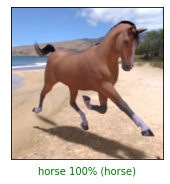

In [27]:
# Visualize the outputs 

# you can modify the index value here from 0 to 255 to test different images
index = 100
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()